# Generating the graph isomorphism dataset

## Setup

In [2]:
FORCE_CPU = True

SAVE_DATA = False
LOAD_DATA = True

BATCH_SIZE = int(1e6)
BATCH_SIZE = int(1e5)

GENERATION_TEST_DATA_FILE = "data/generation_test_data.pkl"
DATASET_FILE = "data/gi_dataset.pkl"

DATASET_CONFIG = dict(
    # Number of samples to generate
    num_samples=100,
    # The size of the graphs. The dataset will be split evenly between the sizes
    # graph_sizes=[7, 8, 9, 10, 11],
    graph_sizes=[7, 8],
    # The edge probabilities to use when generating the graphs
    # edge_probabilities=[0.2, 0.4, 0.6, 0.8],
    edge_probabilities=[0.5],
    # The proportion of samples that consists of non-isomorphic pairs
    prop_non_isomorphic=0.5,
    # Config for the non-isomorphic pairs
    non_isomorphic=dict(
        # The proportion of non-isomorphic pairs with scores 1 and 2. The rest will have
        # scores greater than 2
        prop_score_1=0.1,
        prop_score_2=0.2,
    ),
    isomorphic=dict(
        # The proportion of isomorphic pairs sampled from a non-isomorphic pair
        prop_from_non_isomorphic=0.5,
    ),
)

In [3]:
from collections import Counter, defaultdict
from hashlib import blake2b
import pickle
import itertools
from math import floor

import networkx as nx
from networkx import weisfeiler_lehman_graph_hash, erdos_renyi_graph

import torch
import torch.nn.functional as F

from torch_geometric.utils import dense_to_sparse

import einops

from sklearn.model_selection import ParameterGrid

from tqdm import tqdm

from primesieve.numpy import n_primes

from rich.console import Console
from rich.table import Table

import plotly.graph_objs as go

In [4]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## WL score

In [5]:
def batch_wl_score(
    adjacency_1, adjacency_2, max_iterations=5, hash_size=2**24 - 1, device=device
):
    """
    Compute the Weisfeiler-Lehman graph kernel for a batch of graphs.
    """

    assert adjacency_1.shape[0] == adjacency_2.shape[0]
    assert adjacency_1.shape[1] == adjacency_2.shape[1]

    batch_size = adjacency_1.shape[0]
    num_nodes = adjacency_1.shape[1]

    primes = torch.from_numpy(n_primes(hash_size)).to(device)

    scores = torch.ones(batch_size, dtype=torch.long, device=device) * -1
    labels = torch.ones((2, batch_size, num_nodes), dtype=torch.long, device=device)

    # (graph, batch, node, node)
    adjacency_combined = torch.stack((adjacency_1, adjacency_2), dim=0)
    adjacency_combined += torch.eye(num_nodes, dtype=torch.long, device=device)

    for i in range(max_iterations):
        labels_repeated = einops.repeat(
            labels, "graph batch node1 -> graph batch node2 node1", node2=num_nodes
        )
        labels_neighbours = labels_repeated * adjacency_combined
        labels_neighbours = primes[labels_neighbours]
        labels_neighbours = einops.reduce(
            labels_neighbours, "graph batch node1 node2 -> graph batch node1", "prod"
        )
        labels = torch.remainder(labels_neighbours, hash_size)
        graph_hashes = einops.reduce(
            primes[labels], "graph batch node -> graph batch", "prod"
        )
        diff = graph_hashes[0] != graph_hashes[1]
        scores = torch.where(torch.logical_and(scores == -1, diff), i + 1, scores)

    return scores

## Graph generation

In [6]:
def batch_er_graph(num_samples, graph_size, edge_probability, device=device):
    adjacency_values = torch.rand(num_samples, graph_size, graph_size, device=device)
    adjacency = (adjacency_values < edge_probability).int()
    adjacency = adjacency.triu(diagonal=1)
    adjacency += adjacency.transpose(1, 2).clone()
    return adjacency

## Test generation

In [7]:
num_pairs = int(1e7)
parameter_grid = {
    "edge_prob": [0.2, 0.4, 0.6, 0.8],
    "graph_order": [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}
parameter_iter = ParameterGrid(parameter_grid)

In [8]:
if LOAD_DATA:
    with open(GENERATION_TEST_DATA_FILE, "rb") as f:
        results = pickle.load(f)
else:
    results = {}

    for params in parameter_iter:
        params_tuple = (params["edge_prob"], params["graph_order"])
        results[params_tuple] = {
            "score_2_count": 0,
            "score_gt_2_count": 0,
        }
        for batch_start in tqdm(
            range(0, num_pairs, BATCH_SIZE), desc=f"{params_tuple}"
        ):
            batch_end = min(batch_start + BATCH_SIZE, num_pairs)
            batch_size = batch_end - batch_start
            adjacency_1 = batch_er_graph(
                batch_size, params["graph_order"], params["edge_prob"]
            )
            adjacency_2 = batch_er_graph(
                batch_size, params["graph_order"], params["edge_prob"]
            )
            score = batch_wl_score(adjacency_1, adjacency_2)
            results[params_tuple]["score_2_count"] += torch.sum(score == 2).item()
            results[params_tuple]["score_gt_2_count"] += torch.sum(score > 2).item()
        print(results[params_tuple])

In [9]:
if SAVE_DATA:
    with open(GENERATION_TEST_DATA_FILE, "wb") as f:
        pickle.dump(results, f)

In [10]:
table_2 = Table(title="Number of score 2 pairs")
table_gt_2 = Table(title="Number of score > 2 pairs")

table_2.add_column("Edge prob", justify="right")
table_gt_2.add_column("Edge prob", justify="right")
for graph_order in parameter_grid["graph_order"]:
    table_2.add_column(f"Order {graph_order}", justify="right")
    table_gt_2.add_column(f"Order {graph_order}", justify="right")

for edge_prob in parameter_grid["edge_prob"]:
    table_2.add_row(
        str(edge_prob),
        *[
            str(results[(edge_prob, graph_order)]["score_2_count"])
            for graph_order in parameter_grid["graph_order"]
        ],
    )
    table_gt_2.add_row(
        str(edge_prob),
        *[
            str(results[(edge_prob, graph_order)]["score_gt_2_count"])
            for graph_order in parameter_grid["graph_order"]
        ],
    )

console = Console()
console.print(table_2)
console.print(table_gt_2)

                                              Number of score 2 pairs                                              
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃   Edge ┃  Order ┃  Order ┃  Order ┃  Order ┃  Order ┃  Order ┃ Order ┃  Order ┃ Order ┃  Order ┃ Order ┃  Order ┃
┃   prob ┃      4 ┃      5 ┃      6 ┃      7 ┃      8 ┃      9 ┃    10 ┃     11 ┃    12 ┃     13 ┃    14 ┃     15 ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│    0.2 │      0 │    339 │   2596 │   7371 │   9572 │   8171 │  5781 │   3720 │  2204 │   1346 │   806 │    487 │
│    0.4 │      0 │   6660 │  13316 │  10827 │   6551 │   3546 │  1830 │    975 │   547 │    288 │   178 │     94 │
│    0.6 │      0 │   6531 │  13372 │  10804 │   6418 │   3575 │  1959 │    990 │   529 │    306 │   181 │     92 │
│    0.8 │      0 │    305 │   2744 │   7540 │   9795 │   8187 │  5887 │   3678 │  2235 │   1339 │   854 │    481 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

                                             Number of score > 2 pairs                                             
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃   Edge ┃  Order ┃  Order ┃  Order ┃  Order ┃  Order ┃  Order ┃ Order ┃  Order ┃ Order ┃  Order ┃ Order ┃  Order ┃
┃   prob ┃      4 ┃      5 ┃      6 ┃      7 ┃      8 ┃      9 ┃    10 ┃     11 ┃    12 ┃     13 ┃    14 ┃     15 ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│    0.2 │      0 │      0 │      0 │     27 │     87 │    102 │    69 │     40 │    14 │      5 │     2 │      0 │
│    0.4 │      0 │      0 │      0 │    291 │     96 │     21 │     1 │      0 │     0 │      0 │     0 │      0 │
│    0.6 │      0 │      0 │      0 │    312 │    126 │     18 │     8 │      1 │     0 │      0 │     0 │      0 │
│    0.8 │      0 │      0 │      0 │     24 │    102 │    124 │    65 │     29 │     7 │      5 │     1 │      0 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

In [11]:
# extract data from results dictionary
edge_probs = parameter_grid["edge_prob"]
graph_orders = parameter_grid["graph_order"]
score_2_counts = [[results[(edge_prob, graph_order)]["score_2_count"] for graph_order in graph_orders] for edge_prob in edge_probs]

# create heatmap
heatmap = go.Heatmap(
    z=score_2_counts,
    x=graph_orders,
    y=edge_probs,
    colorscale='Viridis'
)

# create layout
layout = go.Layout(
    title='Score 2 counts',
    xaxis=dict(title='Graph order'),
    yaxis=dict(title='Edge probability')
)

# create figure
fig = go.Figure(data=[heatmap], layout=layout)

# show figure
fig.show()

In [12]:
# extract data from results dictionary
edge_probs = parameter_grid["edge_prob"]
graph_orders = parameter_grid["graph_order"]
score_gt_2_counts = [[results[(edge_prob, graph_order)]["score_gt_2_count"] for graph_order in graph_orders] for edge_prob in edge_probs]

# create heatmap
heatmap = go.Heatmap(
    z=score_gt_2_counts,
    x=graph_orders,
    y=edge_probs,
    colorscale='Viridis'
)

# create layout
layout = go.Layout(
    title='Score > 2 counts',
    xaxis=dict(title='Graph order'),
    yaxis=dict(title='Edge probability')
)

# create figure
fig = go.Figure(data=[heatmap], layout=layout)

# show figure
fig.show()

## Generate dataset

In [13]:
num_non_iso_per = (
    DATASET_CONFIG["num_samples"]
    * DATASET_CONFIG["prop_non_isomorphic"]
    / (len(DATASET_CONFIG["graph_sizes"] * len(DATASET_CONFIG["edge_probabilities"])))
)
num_non_iso_score_per = {}
num_non_iso_score_per["1"] = floor(
    num_non_iso_per * DATASET_CONFIG["non_isomorphic"]["prop_score_1"]
)
num_non_iso_score_per["2"] = floor(
    num_non_iso_per * DATASET_CONFIG["non_isomorphic"]["prop_score_2"]
)
num_non_iso_score_per["gt_2"] = (
    floor(num_non_iso_per) - num_non_iso_score_per["1"] - num_non_iso_score_per["2"]
)
num_iso_from_non_iso = floor(
    DATASET_CONFIG["num_samples"]
    * (1 - DATASET_CONFIG["prop_non_isomorphic"])
    * DATASET_CONFIG["isomorphic"]["prop_from_non_isomorphic"]
)

In [14]:
adjacencies_list = []
sizes_list = []
scores_list = []

num_configs = len(DATASET_CONFIG["graph_sizes"]) * len(
    DATASET_CONFIG["edge_probabilities"]
)
max_graph_size = max(DATASET_CONFIG["graph_sizes"])
for i, (graph_size, edge_probability) in enumerate(
    itertools.product(
        DATASET_CONFIG["graph_sizes"], DATASET_CONFIG["edge_probabilities"]
    )
):
    score_counts = {key: 0 for key in num_non_iso_score_per.keys()}
    progress_bar = tqdm(
        total=sum(num_non_iso_score_per.values()),
        desc=f"[{i+1}/{num_configs+2}] Non-isomorphic (n={graph_size}, p={edge_probability})",
    )
    while any(
        count < num
        for count, num in zip(score_counts.values(), num_non_iso_score_per.values())
    ):
        adjacency_1 = batch_er_graph(BATCH_SIZE, graph_size, edge_probability)
        adjacency_2 = batch_er_graph(BATCH_SIZE, graph_size, edge_probability)
        score = batch_wl_score(adjacency_1, adjacency_2)
        adjacency_1 = F.pad(adjacency_1, (0, max_graph_size - graph_size) * 2)
        adjacency_2 = F.pad(adjacency_2, (0, max_graph_size - graph_size) * 2)
        for key in score_counts.keys():
            if key == "1":
                index = score == 1
            elif key == "2":
                index = score == 2
            elif key == "gt_2":
                index = score > 2
            num_pairs_to_add = min(
                num_non_iso_score_per[key] - score_counts[key],
                torch.sum(index).item(),
            )
            adjacencies_list.append(
                torch.stack(
                    (
                        adjacency_1[index][:num_pairs_to_add],
                        adjacency_2[index][:num_pairs_to_add],
                    )
                )
            )
            sizes_list.append(torch.ones(num_pairs_to_add, dtype=int) *graph_size)
            scores_list.append(score[index][:num_pairs_to_add])
            score_counts[key] += num_pairs_to_add
            progress_bar.update(num_pairs_to_add)
    progress_bar.close()

adjacencies = torch.cat(adjacencies_list, dim=1)
sizes = torch.cat(sizes_list, dim=0)

[2/4] Non-isomorphic (n=8, p=0.5): 100%|██████████| 25/25 [00:01<00:00, 21.31it/s]


In [15]:
print(f"[{num_configs+1}/{num_configs+2}] Isomorphic from non-isomorphic")
batch_index = torch.randint(0, adjacencies.shape[1], (num_iso_from_non_iso,))
pair_index = torch.randint(0, 2, (num_iso_from_non_iso,))
adjacencies_from_non_iso = einops.repeat(
    adjacencies[pair_index, batch_index],
    "pair node1 node2 -> 2 pair node1 node2",
)
sizes_from_non_iso = sizes[batch_index]

[3/4] Isomorphic from non-isomorphic


In [16]:
print(f"[{num_configs+2}/{num_configs+2}] Isomorphic new")
num_new = (
    DATASET_CONFIG["num_samples"]
    - adjacencies.shape[1]
    - adjacencies_from_non_iso.shape[1]
)
num_new_per = floor(
    num_new
    / (len(DATASET_CONFIG["graph_sizes"] * len(DATASET_CONFIG["edge_probabilities"])))
)
adjacencies_new_list = []
sizes_new_list = []
for i, (graph_size, edge_probability) in enumerate(
    itertools.product(
        DATASET_CONFIG["graph_sizes"], DATASET_CONFIG["edge_probabilities"]
    )
):
    if i < num_configs - 1:
        num_new_this = num_new_per
    else:
        num_new_this = num_new - num_new_per * (num_configs - 1)
    adjacency = batch_er_graph(num_new_this, graph_size, edge_probability)
    adjacency = F.pad(adjacency, (0, max_graph_size - graph_size) * 2)
    adjacencies_new_list.append(
        einops.repeat(adjacency, "batch node1 node2 -> 2 batch node1 node2")
    )
    sizes_new_list.append(torch.ones(num_new_this, dtype=int) * graph_size)

[4/4] Isomorphic new


In [17]:
adjacencies = torch.cat(
    (adjacencies, adjacencies_from_non_iso, *adjacencies_new_list), dim=1
)
sizes = torch.cat((sizes, sizes_from_non_iso, *sizes_new_list), dim=0)
scores = torch.cat(scores_list, dim=0)
scores = F.pad(scores, (0, DATASET_CONFIG["num_samples"] - scores.shape[0],), value=-1)

In [18]:
# adjacencies = adjacencies[:, :2, :4, :4]
# adjacencies

In [19]:
node_permutation = torch.argsort(torch.rand(adjacencies.shape[:-1]))
node1_permutation = einops.repeat(
    node_permutation,
    "pair batch node1 -> pair batch node1 node2",
    node2=adjacencies.shape[-1],
)
node2_permutation = einops.repeat(
    node_permutation,
    "pair batch node2 -> pair batch node1 node2",
    node1=adjacencies.shape[-1],
)
adjacencies_shuffled = torch.gather(adjacencies, 2, node1_permutation)
adjacencies_shuffled = torch.gather(adjacencies_shuffled, 3, node2_permutation)
adjacencies_shuffled

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 1, 1],
          [0, 1, 0,  ..., 1, 0, 1],
          ...,
          [0, 0, 1,  ..., 0, 1, 1],
          [0, 1, 0,  ..., 1, 0, 0],
          [0, 1, 1,  ..., 1, 0, 0]],

         [[0, 1, 1,  ..., 0, 0, 1],
          [1, 0, 0,  ..., 1, 0, 0],
          [1, 0, 0,  ..., 0, 0, 1],
          ...,
          [0, 1, 0,  ..., 0, 0, 1],
          [0, 0, 0,  ..., 0, 0, 0],
          [1, 0, 1,  ..., 1, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 0, 1],
          ...,
          [0, 1, 1,  ..., 0, 0, 1],
          [0, 1, 0,  ..., 0, 0, 0],
          [0, 1, 1,  ..., 1, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 1, 1, 0],
          [0, 0, 0,  ..., 1, 1, 1],
          ...,
          [0, 1, 1,  ..., 0, 1, 0],
          [0, 1, 1,  ..., 1, 0, 1],
          [0, 0, 1,  ..., 0, 1, 0]],

         [[0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 

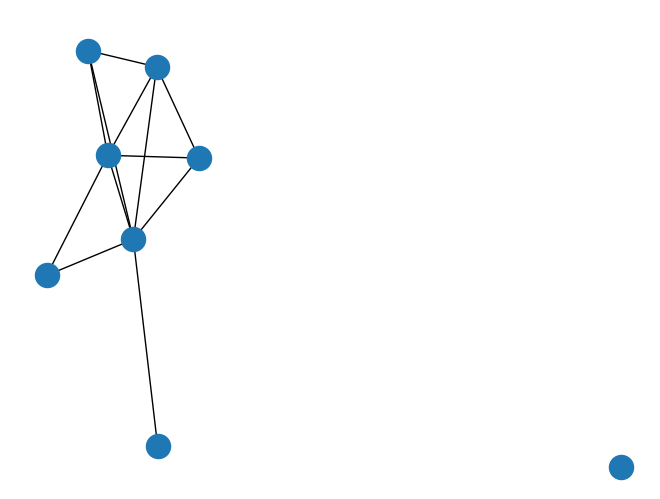

In [20]:
nx.draw(nx.from_numpy_array(adjacencies[1, 0].numpy()))

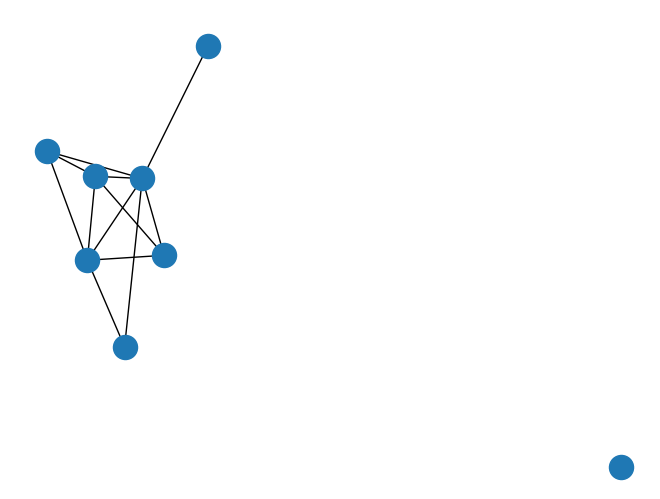

In [21]:
nx.draw(nx.from_numpy_array(adjacencies_shuffled[1, 0].numpy()))

tensor([7])


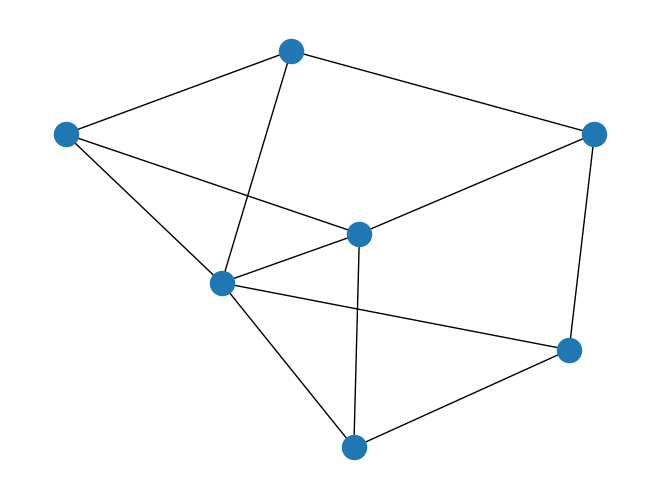

In [22]:
batch_id = torch.randint(0, adjacencies.shape[1], (1,))
adjacency = adjacencies[:, batch_id, :sizes[batch_id], :sizes[batch_id]].squeeze()
graph_1 = nx.from_numpy_array(adjacency[0].numpy())
graph_2 = nx.from_numpy_array(adjacency[1].numpy())
print(sizes[batch_id])
nx.draw(graph_1)

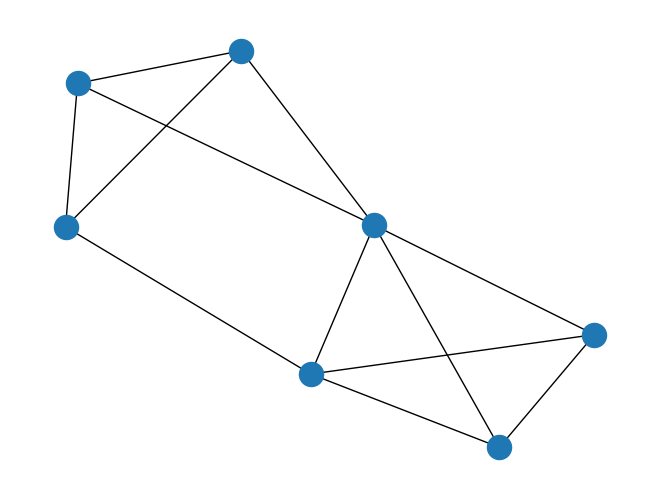

In [23]:
nx.draw(graph_2)

In [24]:
indices = torch.arange(1, adjacencies.shape[1] + 1)
indices = einops.rearrange(indices, "batch -> () batch () ()")
adjacencies_indexed = adjacencies * indices

edge_indices_a, batch_a = dense_to_sparse(adjacencies_indexed[0])
edge_indices_b, batch_b = dense_to_sparse(adjacencies_indexed[1])

slices_a = torch.cumsum(torch.bincount(batch_a), 0)
slices_b = torch.cumsum(torch.bincount(batch_b), 0)

In [25]:
data = dict(
    edge_index_a=edge_indices_a,
    edge_index_b=edge_indices_b,
    slices_a=slices_a,
    slices_b=slices_b,
    wl_scores=scores,
    sizes_a=sizes,
    sizes_b=sizes,
)

In [26]:
torch.save(data, DATASET_FILE)

# Test package implementation

In [54]:
from pvg.dataset_generation import generate_gi_dataset, GraphIsomorphicDatasetConfig

config = GraphIsomorphicDatasetConfig(
    num_samples=DATASET_CONFIG["num_samples"],
    graph_sizes=DATASET_CONFIG["graph_sizes"],
    edge_probabilities=DATASET_CONFIG["edge_probabilities"],
    max_iterations=5,
    prop_non_isomorphic=DATASET_CONFIG["prop_non_isomorphic"],
    non_iso_prop_score_1=DATASET_CONFIG["non_isomorphic"]["prop_score_1"],
    non_iso_prop_score_2=DATASET_CONFIG["non_isomorphic"]["prop_score_2"],
    iso_prop_from_non_iso=DATASET_CONFIG["isomorphic"]["prop_from_non_isomorphic"],
)

generate_gi_dataset(config, "test", batch_size=BATCH_SIZE, device=device)

[1/4] Non-isomorphic (n=7, p=0.5):   0%|          | 0/25 [00:00<?, ?it/s]

[2/4] Non-isomorphic (n=8, p=0.5): 100%|██████████| 25/25 [00:00<00:00, 35.38it/s]

[3/4] Isomorphic from non-isomorphic
[4/4] Isomorphic new
Done


In [55]:
from pvg.data import GraphIsomorphismDataset
from pvg.parameters import Parameters

dataset = GraphIsomorphismDataset(Parameters("graph_isomorphism", "test", "test"))

In [56]:
dataset._data

GraphIsomorphismData(edge_index_a=[2, 2478], edge_index_b=[2, 2492], wl_score=[100], x_a=[754, 8], x_b=[754, 8])

In [57]:
dataset

GraphIsomorphismDataset(name='test', num_features=8, num_pairs=100)